In [1]:

import torch
import os
import random
from torch.utils.data import Dataset
from torch.utils.data import DataLoader, TensorDataset

import librosa
import librosa.display
import numba.decorators
import numpy as np
import matplotlib.pyplot as plt
from numba.decorators import jit as optional_jit




from google.colab import auth
auth.authenticate_user()

from google.colab import drive
drive.mount('/content/gdrive')


#PATH = 'C://Projects//keras_talk//keras//intern//dataset//'
PATH = '/content/gdrive/My Drive/dataset/'


BATCH_SIZE = 40




Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


#
###### y_data 
class를

[ 80, 60, 40, 20, 0, X , 180, 160, 140, 120, 100 ] 순서로 구성하였습니다.


In [2]:
# def Y_DATA(y_data):
#    for idx in range(y_data.shape[0]):
#        y = y_data[idx]
#        if y < 0:  y_data[idx] = 10
#        else:      y_data[idx] = (y//20)
#    return y_data

# [ 0, 20, 40, 60, 80, 100, 120, 140, 160, 180, X ]



def Y_DATA(y_data):
    for idx in range(y_data.shape[0]):
        y = y_data[idx]
        if y < 0:      y_data[idx] = 5
        elif y < 90:   y_data[idx] = 4-(y//20) 
        else:          y_data[idx] = 15-(y//20)

    return y_data

# [ 80, 60, 40, 20, 0, X , 180, 160, 140, 120, 100 ]



In [3]:

'''  y <<=  angle.mat의 phi[1:1000] '''
y =  np.load(PATH + 'angle.npy') 




In [4]:


dataset_dict = { 0 : 'S_left',        1 : 'S_left_phase',
                 2 : 'S_right',       3 : 'S_right_phase',
                 4 : 'clean_left',    5 : 'clean_left_phase',
                 6 : 'clean_right',   7 : 'clean_right_phase',
                 8 : 'idx_drone_end', 9 : 'idx_voice_end',
                10 : 'idx_voice_start'}




x_data_list = [    0,        2,          1,             3        ]
#                S_left   S_right   S_left_phase   S_right_phase



numpy_dict = dict()
for n in x_data_list:
    numpy_name    = dataset_dict[n]
    numpy_dict[n] = np.load( PATH + numpy_name + '.npy' )

    print(dataset_dict[n])



# .shape = (257, 382, 1000)
S_L_mag = numpy_dict[0]
S_L_phase = numpy_dict[1]
S_R_mag = numpy_dict[2]
S_R_phase = numpy_dict[3]



S_left
S_right
S_left_phase
S_right_phase


##### Nomalization

In [5]:
"""
(257, 382) size의  numpy array 2개를 
위아래로 붙인 뒤  ( 257*2, 382 ) size로 만들어 주고

( 257 * 2 * 382 )개의 sample에 대한 평균, 표준편차로
정규화해주었습니다.

정규화된 numpy array (z) 의 shape을 (2, 257, 382)로 바꿔주고
반환값은 tuple type으로 z[0]은 정규화된 left magnitude
                        z[1]은 정규화된 right magnitude입니다.
"""

def Mag_normalization( L, R ):
    
    samples = np.concatenate((L,R), axis=0)
    mu = np.mean( samples )
    sigma = np.std( samples )

    z = (samples-mu) / sigma
    z = z.reshape(2, L.shape[0], L.shape[1])
    
    return z[0], z[1]



"""
left phase와 right phase의 정규화는 따로 해주었습니다. """

def Phase_normalization( phase ):
    mu = np.mean( phase )
    sigma = np.std( phase )
    
    z = ( phase - mu ) / sigma
    return z

# 

##### x_data 전처리

1) x_data list 초기화

2) (for) total data 개수인 1000번동안

    -left, right mag의 idx 번째 array(257,382) 불러오기
    -magnitude log 변환, 정규화
    -left, right phase의 idx 번째 array(257,382) 불러오기, 정규화

    -초기화된 list인 x_element에 삽입 (4,257,382)
    - x_element의 type을 numpy array로 변환 후 x_data에 삽입

3) type(x_data)을 numpy array로 변환

In [6]:

# x_data 초기화
x_data = []


'''    x_data,       y_data '''
'''(1000,4,257,382), (1000,)'''


for idx in range(1000):

    # list 초기화
    x_element = []


    """ Mag """
    # S_left,  S_right 의 idx번째 array
    x_L = S_L_mag[:,:,idx]
    x_R = S_R_mag[:,:,idx]



    """log scale [dB]"""
    x_L_dB = 20*np.log10( np.abs(x_L) + np.finfo(np.float32).eps )
    x_R_dB = 20*np.log10( np.abs(x_R) + np.finfo(np.float32).eps )
    #x_L = librosa.amplitude_to_db(x_L)
    #x_R = librosa.amplitude_to_db(x_R)



    """phase"""
    # S_left_phase,  S_right_phase 의 idx번째 array
    x_L_phase =  S_L_phase[:,:,idx] 
    x_R_phase =  S_R_phase[:,:,idx] 

    


    """normalization"""
    x_L, x_R = Mag_normalization(x_L_dB, x_R_dB)
    x_L_phase = Phase_normalization( x_L_phase )
    x_R_phase = Phase_normalization( x_R_phase )




    """x_element.shape ==> (4, 257, 382)"""
    # 초기화된 list( x_element )에 
    # left, right의 mag[dB], phase[rad] 총 4개의 array 삽입 
    x_element.append(x_L)
    x_element.append(x_R)
    x_element.append(x_L_phase)
    x_element.append(x_R_phase)



    # x_element 의 type을 list에서 numpy array로 변환후 
    #x_data list에 삽입
    x_data.append( np.asarray(x_element) )



# x_data의 type을 list에서 numpy array로 변환
x_data = np.asarray(x_data)

# 0,20,40,60...180,-1 인 y_data를  Y_DATA 함수로 
# 0,1,2,....,9,10 으로 변환
y_data = Y_DATA( y )


print('x_data:', x_data.shape)
print('y_data:', y_data.shape)



x_data: (1000, 4, 257, 382)
y_data: (1000, 1)


In [7]:

train_size = 800
valid_size = 200


x_data = torch.from_numpy( x_data ).float().to('cuda')
y_data = torch.from_numpy( y_data ).long().to('cuda').reshape(1000,)

full_dataset = TensorDataset( x_data, y_data )

# 8:2 비율로 랜덤
train_data, valid_data = torch.utils.data.random_split( full_dataset, [train_size, valid_size])
train_dataset = DataLoader( dataset=train_data, batch_size = BATCH_SIZE, shuffle=True, drop_last=True)
valid_dataset = DataLoader( dataset=valid_data, batch_size = BATCH_SIZE, shuffle=True, drop_last=True)


CNN Model은 이전에 MNIST분류에 사용한 model에서

convolution layer 한 개를 추가하였습니다.


첫번째 convolution layer에서 kernel size는 (7,7) stride가 (2,2)이고

, 두번째, 세번째 convolution layer에서 kernel size는 (3,3) stride는 (1,1)입니다.






In [17]:
import re
import torch.nn as nn
import torch.nn.functional as F



class CNN (nn.Module):
    def __init__(self):
        super(CNN, self).__init__()
        ''' 4 * 257 * 382'''
        self.conv1 = nn.Conv2d( in_channels=  4, out_channels= 64, kernel_size = (7,7), stride = (2,2) )
        #relu
        #pooling
        
        ''' 64 * 62 * 94'''
        self.conv2 = nn.Conv2d( in_channels= 64, out_channels= 64, kernel_size = (3,3) )
        #relu
        #pooling


        ''' 64 * 30 * 46'''
        self.conv3 = nn.Conv2d( in_channels= 64, out_channels= 32, kernel_size = (3,3) )
        #relu
        #pooling


        ''' 32 * 14 * 22'''
        #flatten

        self.lay1  = nn.Linear( 32*14*22, 256)
        self.lay2  = nn.Linear( 256, 256 )
        self.lay3  = nn.Linear( 256, 64 )
        self.lay4  = nn.Linear( 64 , 11 )
        


        # xavier initialization
        nn.init.xavier_uniform_(self.conv1.weight)
        nn.init.xavier_uniform_(self.conv2.weight)
        nn.init.xavier_uniform_(self.conv3.weight)
        
        # kaiming he initialization
        nn.init.kaiming_uniform_(self.lay1.weight)
        nn.init.kaiming_uniform_(self.lay2.weight)
        nn.init.kaiming_uniform_(self.lay3.weight)
        nn.init.kaiming_uniform_(self.lay4.weight)


        
    def forward(self, output):
        output = F.max_pool2d( F.relu( self.conv1(output) ),2 )
        output = F.max_pool2d( F.relu( self.conv2(output) ),2 )
        output = F.max_pool2d( F.relu( self.conv3(output) ),2 )
        
        output = output.view(-1, 32*14*22)
        
        output = F.relu( self.lay1(output) )
        output = F.dropout(output, training=self.training)
        output = F.relu( self.lay2(output) )
        output = F.dropout(output, training=self.training)
        output = F.relu( self.lay3(output) )
        output = F.dropout(output, training=self.training)
        output = F.log_softmax(self.lay4(output), dim=1)
        
        return output
    

In [18]:

model = CNN().to('cuda')
model


CNN(
  (conv1): Conv2d(4, 64, kernel_size=(7, 7), stride=(2, 2))
  (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1))
  (conv3): Conv2d(64, 32, kernel_size=(3, 3), stride=(1, 1))
  (lay1): Linear(in_features=9856, out_features=256, bias=True)
  (lay2): Linear(in_features=256, out_features=256, bias=True)
  (lay3): Linear(in_features=256, out_features=64, bias=True)
  (lay4): Linear(in_features=64, out_features=11, bias=True)
)

###### Model 학습

epoch 50, batch size 40

optimizer

    - Adagrad
    - Adam
    - SGD



In [19]:


torch.manual_seed(100)
criterion = nn.CrossEntropyLoss().to('cuda')


'''optimizer'''

optimizer = torch.optim.Adagrad(model.parameters(), lr=0.0001, weight_decay=0.9)
TITLE = 'Adagrad (weight_decay=0.9)'

#optimizer = torch.optim.Adam(model.parameters(), lr=0.00001)
#TITLE = 'Adam'

#optimizer = torch.optim.SGD(model.parameters(), lr=0.00001, momentum=0.9)
#TITLE = 'SGD (momentum=0.9)'




EPOCHS = 100

train_loss = []
train_acc  = []

torch_pred  = torch.empty((1,), dtype=torch.int32).to('cuda')
torch_label = torch.empty((1,), dtype=torch.int32).to('cuda')



model.train()
for epoch in range(EPOCHS):
    #print('epoch ' + str(epoch+1))
    total_loss = 0.0
    total_acc = 0
    
    
    for i, (data, label) in enumerate(train_dataset):
        (data, label) = (data.to('cuda'), label.to('cuda'))

        #zero the parameter gradients
        optimizer.zero_grad()        

        # forward + backward = optimize
        output = model(data)
        loss = criterion(output, label)
        loss.backward()
        optimizer.step()
        

        """loss, accuracy"""
        # batch 정확도
        preds  = torch.max(output.data, 1)[1]
        corr  = (preds==label).sum().item()
        acc   = corr/BATCH_SIZE*100

        # epoch 손실도, 정확도
        total_loss += loss.item()
        total_acc += corr
    
        # batch 손실도, 정확도 출력, 저장
        train_loss.append(loss)
        train_acc.append(acc)
        #if i%5==0: print('\tLoss: {:.3f}\tAcc: {:.3f}'.format(loss.item(), acc))


        """ confusion matrix"""
        if epoch == EPOCHS-1:
            torch_pred  = torch.cat( [ torch_pred , preds.to( 'cuda', dtype=torch.int32) ], dim=0 )
            torch_label = torch.cat( [ torch_label, label.to( 'cuda', dtype=torch.int32) ], dim=0 )


    # epoch 손실도, 정확도 출력
    print('epoch' + str(epoch+1) + '  >> Loss: {:.3f} \tAcc: {:.3f}'.format( total_loss, total_acc/800*100 ))
    #print()

    #confusion matrix
    stacked = torch.stack( ( torch_label[1:], torch_pred[1:] ), dim=1 )



epoch1  >> Loss: 52.081 	Acc: 8.375
epoch2  >> Loss: 49.742 	Acc: 8.875
epoch3  >> Loss: 49.299 	Acc: 10.125
epoch4  >> Loss: 49.057 	Acc: 8.750
epoch5  >> Loss: 48.776 	Acc: 10.000
epoch6  >> Loss: 48.677 	Acc: 9.875
epoch7  >> Loss: 48.588 	Acc: 9.250
epoch8  >> Loss: 48.513 	Acc: 8.875
epoch9  >> Loss: 48.170 	Acc: 11.125
epoch10  >> Loss: 48.692 	Acc: 8.750
epoch11  >> Loss: 48.261 	Acc: 11.125
epoch12  >> Loss: 48.621 	Acc: 8.875
epoch13  >> Loss: 48.322 	Acc: 11.250
epoch14  >> Loss: 48.475 	Acc: 9.875
epoch15  >> Loss: 48.417 	Acc: 9.750
epoch16  >> Loss: 48.438 	Acc: 11.125
epoch17  >> Loss: 48.339 	Acc: 10.000
epoch18  >> Loss: 48.187 	Acc: 10.875
epoch19  >> Loss: 48.184 	Acc: 9.625
epoch20  >> Loss: 48.319 	Acc: 10.500
epoch21  >> Loss: 48.426 	Acc: 7.125
epoch22  >> Loss: 48.298 	Acc: 9.500
epoch23  >> Loss: 48.294 	Acc: 9.875
epoch24  >> Loss: 48.484 	Acc: 10.000
epoch25  >> Loss: 47.991 	Acc: 8.625
epoch26  >> Loss: 48.208 	Acc: 8.750
epoch27  >> Loss: 48.106 	Acc: 9.750


training loss, training accuracy

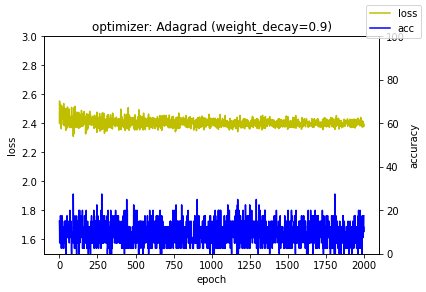

In [11]:

%matplotlib inline
fig, loss_ax = plt.subplots()
acc_ax = loss_ax.twinx()

loss_ax.plot(np.asarray(train_loss), 'y')
acc_ax.plot( np.asarray(train_acc),  'b')

loss_ax.set_xlabel('epoch')
loss_ax.set_ylabel('loss')
loss_ax.set_ylim([1.5, 3])

acc_ax.set_ylabel('accuracy')
acc_ax.set_ylim([0, 100])

fig.legend(['loss','acc'], loc='upper right')
plt.title('optimizer: '+TITLE)
plt.savefig(PATH+TITLE+'.png')
plt.show()

###### train_dataset confusion matrix

마지막 epoch에서의 confusion matrix 입니다.

In [12]:

idx = 12


cmt = torch.zeros(11,11, dtype=torch.int32)

for p in stacked:
    tl, pl = p.tolist()
    cmt[tl, pl] += 1

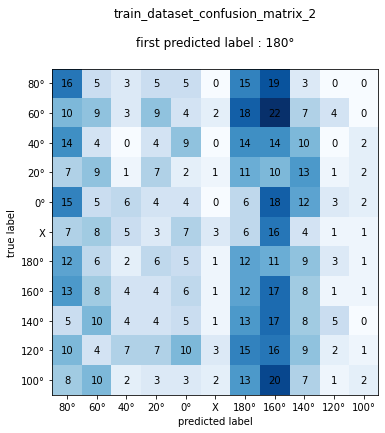

In [13]:
from sklearn.metrics import confusion_matrix
from mlxtend.plotting import plot_confusion_matrix


axis = ['80\u00b0','60\u00b0','40\u00b0','20\u00b0','0\u00b0','X','180\u00b0','160\u00b0','140\u00b0','120\u00b0','100\u00b0']
#axis = ['X','0\u00b0','20\u00b0','40\u00b0','60\u00b0','80\u00b0','100\u00b0','120\u00b0','140\u00b0','160\u00b0','180\u00b0']


plot_confusion_matrix(cmt.numpy())


plt.title('train_dataset_confusion_matrix_2' + '\n\n' + 
          'first predicted label : '+ axis[  int( torch_pred[1] ) ])

plt.xticks(np.arange(11), axis)
plt.yticks(np.arange(11), axis)
plt.gcf().set_size_inches(6,6,forward=True)

plt.savefig( PATH + 'train_dataset_confusion_matrix' + str(idx) + '.png' )
plt.show()

In [14]:
model.eval().to('cuda')




with torch.no_grad():
    correct = 0
    total = 0

    #confusion matrix
    torch_pred_valid  = torch.empty((1,), dtype=torch.int32).to('cuda')
    torch_label_valid = torch.empty((1,), dtype=torch.int32).to('cuda')

    for data, label in valid_dataset:
        output = model(data)
        preds  = torch.max(output.data, 1)[1]
        total   += len(label)
        
        label = label.reshape(BATCH_SIZE)
        correct += (preds==label).sum().item()


        #confusion matrix
        torch_pred_valid  = torch.cat( [ torch_pred_valid , preds.to( 'cuda', dtype=torch.int32) ], dim=0 )
        torch_label_valid = torch.cat( [ torch_label_valid, label.reshape(BATCH_SIZE).to( 'cuda', dtype=torch.int32) ], dim=0 )

    valid_stacked = torch.stack( ( torch_label_valid[1:], torch_pred_valid[1:] ), dim=1 )



      
    print('Test Accuracy: ', 100.*correct/total)

Test Accuracy:  10.5


validation dataset 

confusion matrix


In [15]:

cmt_valid = torch.zeros(11,11, dtype=torch.int32)

for p in valid_stacked:
    tl, pl = p.tolist()
    cmt_valid[tl, pl] += 1

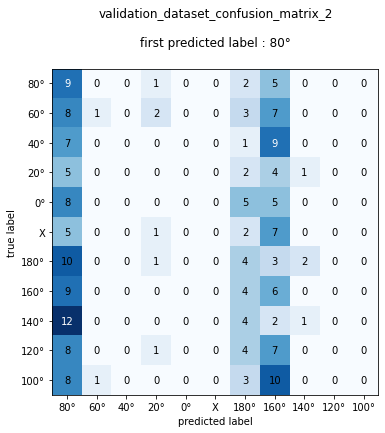

In [16]:

plot_confusion_matrix(cmt_valid.numpy())



plt.title('validation_dataset_confusion_matrix_2' + '\n\n' + 
          'first predicted label : '+ axis[  int( torch_pred_valid[1] ) ])
plt.xticks(np.arange(11), axis)
plt.yticks(np.arange(11), axis)
plt.gcf().set_size_inches(6,6,forward=True)


plt.savefig( PATH + 'validation_dataset_confusion_matrix' + str(idx) + '.png' )
plt.show()
